### Imports

In [1]:
from dlcliche.image import *
sys.path.append('..') # app
sys.path.append('../..') # root
from easydict import EasyDict
from app_utils_clf import *
from whale_utils import *
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Sampler
import seaborn as sns

### Parameters

In [2]:
args = EasyDict()
args.distance = 'l2'
args.n_train = 2
args.n_test = 2
args.q_train = 3
args.q_test = 3

args.k_train = 50
args.k_test = 50
SZ = 256
RE_SZ = 256

args.n_epochs = 100
args.drop_lr_every = 50
args.lr = 1e-4
args.init_weight = None

data_train = DATA_PATH
data_test  = DATA_PATH

args.checkpoint_monitor = 'categorical_accuracy'
args.checkpoint_period = 20

### Dataset

In [3]:
DATA_PATH = Path('/home/raghava_balusu_walmartlabs_com/Work/IRAS/data/DT_1242/iras-products/cropped') 

imgs = list(DATA_PATH.rglob('*.png'))

upcs = set([i.name[:-4].split('_')[1] for i in imgs])

imgs_df = pd.DataFrame({'fpath' : imgs, 'upc' : [i.name[:-4].split('_')[1] for i in imgs], 'fname' : [i.name[:-4] for i in imgs]})

In [4]:
imgs_df.head()

,fpath,upc,fname
0,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00814238021900,4_00814238021900
1,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00038000991806,248_00038000991806
2,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00409800835926,10_00409800835926
3,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00044600159324,26_00044600159324
4,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00786162005212,5_00786162005212


In [5]:
proto_df= imgs_df[imgs_df.upc.isin(imgs_df.groupby('upc').size()[imgs_df.groupby('upc').size()>=10].index.values)].reset_index(drop=True)

In [6]:
proto_df.tail()

,fpath,upc,fname
7995,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00076410904504,29_00076410904504
7996,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00051500826010,17946_00051500826010
7997,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00300258901198,29_00300258901198
7998,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00660094100095,8_00660094100095
7999,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00037000779612,0_00037000779612


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
sss.get_n_splits(proto_df.fpath, proto_df.upc)
train_index, val_index = list(sss.split(proto_df.fpath, proto_df.upc))[0]

In [8]:
proto_df['type'] = 'train'
proto_df.loc[val_index, 'type'] = 'valid'

In [9]:
le = LabelEncoder()
proto_df['label_id'] = le.fit_transform(proto_df.upc)

proto_df.head()

,fpath,upc,fname,type,label_id
0,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00814238021900,4_00814238021900,train,722
1,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00038000991806,248_00038000991806,valid,179
2,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00409800835926,10_00409800835926,train,628
3,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00044600159324,26_00044600159324,valid,230
4,/home/raghava_balusu_walmartlabs_com/Work/IRAS...,00786162005212,5_00786162005212,valid,707


In [10]:
proto_df.groupby(['upc', 'type']).size().mean()

5.0

In [11]:
trn_df = proto_df[proto_df.type == 'train'].reset_index(drop=True)
val_df = proto_df[proto_df.type == 'valid'].reset_index(drop=True)

#### Datset and DataLoader

In [12]:
args.episodes_per_epoch = roundup((trn_df[trn_df.type == 'train'].upc.nunique())/args.k_train, 1)
args.evaluation_episodes = 100 # setting small value, anyway validation set is almost useless here

In [13]:
args.episodes_per_epoch

16

In [14]:
def get_aug_custom(re_size=224, to_size=224, train=True):
    augs = [A.Resize(height=re_size, width=re_size)]
    if train:
        augs.extend([
            A.RandomCrop(height=to_size, width=to_size),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=30, p=0.75),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.75),
            A.Blur(p=0.5),
            A.Cutout(max_h_size=to_size//12, max_w_size=to_size//12, p=0.5),
        ])
    else:
        augs.extend([A.CenterCrop(height=to_size, width=to_size)])
    return A.Compose(augs + [A.Normalize()])

In [15]:
def get_aug_plus_custom(re_size=224, to_size=224, augment='train', normalize='imagenet'):
    augs = [A.Resize(height=re_size, width=re_size)]
    if augment == 'train':
        augs.extend([
            A.RandomCrop(height=to_size, width=to_size),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=30, p=0.75),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.75),
            A.Blur(p=0.5),
            A.Cutout(max_h_size=to_size//12, max_w_size=to_size//12, p=0.5),
        ])
    elif augment == 'train_hard':
        augs.extend([
            A.RandomCrop(height=to_size, width=to_size),
            A.IAAAffine(scale=1.3, translate_percent=0.2, translate_px=None,
                                        rotate=40, shear=20),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.75),
            A.IAAPerspective(p=1),
            A.IAAAdditiveGaussianNoise(p=0.2),
            A.Blur(p=0.5),
            A.Cutout(max_h_size=to_size//12, max_w_size=to_size//12, p=0.5),
        ])
    elif augment == 'test':
        augs.extend([
            A.CenterCrop(height=to_size, width=to_size)
        ])
    elif augment == 'tta':
        augs.extend([
            A.IAAAffine(scale=1.05, translate_percent=0.1, translate_px=None, 
                        rotate=20, shear=10),
            A.CenterCrop(height=to_size, width=to_size),
        ])
    else:
        raise Exception(f'aug level not supported: {augment}')
    return A.Compose(augs + [A.Normalize()])

In [16]:
class GrocerImages(Dataset):
    def __init__(self, path, df, re_size=256, to_size=256, train=True):
        self.df = df.reset_index(drop=True)
        # Index should be same in reference and query df compared to original df
#         self.support_df = self.df
#         self.query_df = self.df
        
        self.classes = sorted(list(set(self.df.label_id.values)))

        self.loader = get_img_loader(path, to_gray=False)
        self.transform = get_aug_custom(re_size=re_size, to_size=to_size, train=train)
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, item):
        instance = self.loader(self.df.loc[item, 'fpath'])
        instance = self.transform(image=instance)['image']
        instance = self.to_tensor(instance)
        label = self.df.loc[item, 'label_id']
        return instance, label

    def __len__(self):
        return len(self.df)

    def num_classes(self):
        return len(self.cls2imgs)

In [17]:
class GrocerImages_plus(GrocerImages):
    def __init__(self, path, df, re_size=256, to_size=224, part=0, n_part=1,
                 augment='normal', normalize='samplewise'):
        super().__init__(path, df, re_size=re_size, to_size=to_size, train=(augment=='train'))
        self.df = df.reset_index(drop=True)
        # Index should be same in reference and query df compared to original df

        self.transform = get_aug_plus_custom(re_size=re_size, to_size=to_size, augment=augment, normalize=normalize)
        self.part, self.n_part = part, n_part

    def __getitem__(self, item):
        instance = self.loader(self.df.loc[item, 'image_path'])
#         if self.n_part > 1:
#             instance = partition_np_image(instance, self.part, n_part=self.n_part)
        instance = self.transform(image=instance)['image']
        instance = self.to_tensor(instance)
        label = self.df.loc[item, 'label_id']
        return instance, label

In [18]:
class NShotTaskSampler_custom(Sampler):
    def __init__(self, dataset, episodes_per_epoch, n, k, q):

        super(NShotTaskSampler_custom, self).__init__(dataset)
        self.episodes_per_epoch = episodes_per_epoch
        self.dataset = dataset

        # TODO: Raise errors if initialise badly
        self.k = k
        self.n = n
        self.q = q

    def __len__(self):
        return self.episodes_per_epoch

    def __iter__(self):
        for _ in range(self.episodes_per_epoch):
            batch = []
            # Get random classes
            df = self.dataset.df
#             query_df = self.dataset.query_df
            episode_classes = np.random.choice(df['label_id'].unique(), size=self.k, replace=False)
            
            #df = self.dataset.df[self.dataset.df['class_id'].isin(episode_classes)]

            for k in episode_classes:
                # Select support examples
                support = df[df['label_id'] == k].sample(self.n)
                
                for i, s in support.iterrows():
                    batch.append(i)

            for k in episode_classes:
                try :
                    temp = df[df['label_id'] == k]
                    query = temp.iloc[~(temp.index.isin(batch)),:].sample(self.q)
                except:
                    pass
#                     query = query_df[query_df['label_id'] == k].sample(self.q, replace=True)
                for i, q in query.iterrows():
                    batch.append(i)

        yield np.stack(batch)

In [19]:
# Dataloader
background = GrocerImages(path='/', df=trn_df, re_size=RE_SZ, to_size=SZ)
background_taskloader = DataLoader(background, batch_sampler=NShotTaskSampler_custom(background, args.episodes_per_epoch, 
                            args.n_train, args.k_train, args.q_train),num_workers=8)

evaluation = GrocerImages(path='/', df=val_df, re_size=RE_SZ, to_size=SZ, train=False)

evaluation_taskloader = DataLoader(evaluation, 
            batch_sampler=NShotTaskSampler_custom(evaluation, args.episodes_per_epoch, args.n_test, args.k_test, args.q_test),
    num_workers=8)

#### Loaders Checking

In [20]:
x = next(iter(background_taskloader))

sx = x[0][:args.k_train*args.n_train, ...]
qx = x[0][args.k_train*args.n_train:, ...]

sy = x[1][:args.k_train*args.n_train]
qy = x[1][args.k_train*args.n_train:]

sorted(sy.unique()) == sorted(qy.unique())

True

In [21]:
%matplotlib inline
def show(img):
    img1 = img.numpy()
    img1 = np.transpose(img1, (1,2,0))
    img1 = (img1*std1) + mean1
    #img = img*255.
#     print(img1.shape)
    plt.imshow(img1)#, interpolation = 'nearest')
#     return img1

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

mean1 = mean[None, None, :]
std1 = std[None, None, :]

In [22]:
idx = np.random.randint(0, args.k_train)
imgs = torch.cat((sx[sy == sy.unique()[idx], ...], qx[qy ==sy.unique()[idx], ...]), dim=0)

imgs = torch.FloatTensor(imgs)

In [23]:
len(imgs)

5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


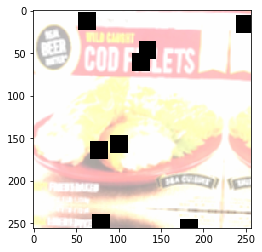

In [24]:
show(imgs[0]); 

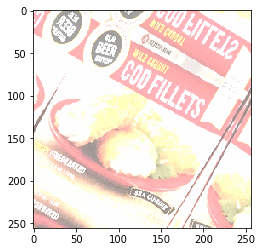

In [25]:
show(imgs[1]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


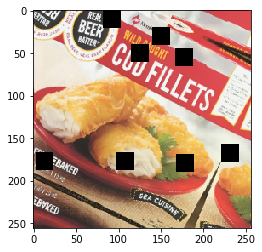

In [26]:
show(imgs[2])

### Modeling
* Pretraining with retail data
* lr_finder
* Freeze Initial layers and train only last layers
* fit_one_cycle
* disriminative learning rates

#### Lr_Finder

In [27]:
from few_shot.proto import proto_net_episode
from few_shot.core import prepare_nshot_task
from torch_lr_finder import LRFinder
from torch import optim

  pip install torch-lr-finder -v --global-option="amp"


In [28]:
from torch_lr_finder.lr_finder import DataLoaderIterWrapper

In [29]:
feature_model = get_resnet34(device=device, weight_file=args.init_weight)

In [30]:
criterion = torch.nn.NLLLoss()

In [31]:
optimizer = optim.Adam(feature_model.parameters(), lr=1e-7)

In [32]:
class lr_finder_proto(LRFinder):
    
    def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
        super().__init__(model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None)
        self.prepare_batch = prepare_nshot_task(args.n_train, args.k_train, args.q_train)
    
#     def range_test(self, train_loader, val_loader=None, start_lr=None, end_lr=10, num_iter=100, step_mode="exp",
#                     smooth_f=0.05, diverge_th=5, accumulation_steps=1):
#         super().__init__(train_loader, val_loader=None, start_lr=None, end_lr=10, num_iter=100, step_mode="exp",
#                     smooth_f=0.05, diverge_th=5, accumulation_steps=1)
#         self.dl = DataLoaderIterWrapper(train_loader)
    
    def _train_batch(self, iter_wrapper, accumulation_steps):
#         self.model.train()
        total_loss = None  # for late initialization

#         self.optimizer.zero_grad()
        for i in range(accumulation_steps):
            batch = iter_wrapper.get_batch()
            inputs, labels = self.prepare_batch(batch)
#             print(inputs.shape, labels.shape)
            # Forward pass
            loss, y_pred = proto_net_episode(self.model, self.optimizer, self.criterion, inputs, labels, 
                                        args.n_train, args.k_train, args.q_train, distance ='l2' ,train =True)
            
            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
#             loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss
        
        if len(self.history['lr'])>0:
            print(loss, self.history["lr"][-1])

        return total_loss.item()


In [33]:
lr_finder = lr_finder_proto(feature_model, optimizer, criterion, device="cuda", cache_dir = 'logs')

In [ ]:
lr_finder.range_test(background_taskloader, end_lr=100, num_iter=150, smooth_f=0.5)

tensor(43.8708, device='cuda:0', grad_fn=<DivBackward0>) 1.1481536214968827e-07


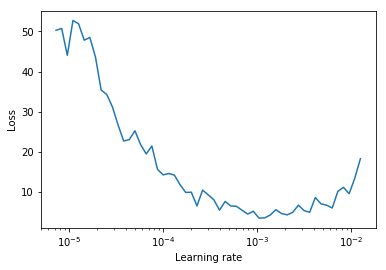

In [51]:
lr_finder.plot(skip_start=30, skip_end=0) # to inspect the loss-learning rate graph

In [53]:
lr_finder.reset() # to reset the model and optimizer to their initial state

#### Training

In [33]:
feature_model = get_resnet34(device=device, weight_file=args.init_weight)

In [34]:
args.param_str = f'BC_q{args.q_train}k{args.k_train}_rq5_ref1.5k'
args.param_str

'BC_q2k100_rq5_ref1.5k'

In [35]:
train_proto_net(args,
                model=feature_model,
                device=device,
                path='.',
                n_epochs=args.n_epochs,
                background_taskloader=background_taskloader,
                evaluation_taskloader=evaluation_taskloader,
                drop_lr_every=args.drop_lr_every,
                evaluation_episodes=args.evaluation_episodes,
                episodes_per_epoch=args.episodes_per_epoch,
                lr=args.lr,
               )

Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Begin training...


Epoch 100:  12%|█▎        | 2/16 [00:11<01:30,  6.44s/it, loss=2.58, categorical_accuracy=0.965, val_1-shot_34-way_acc=0.694]

Finished.


In [36]:
train_proto_net(args,
                model=feature_model,
                device=device,
                path='.',
                n_epochs=50,
                background_taskloader=background_taskloader,
                evaluation_taskloader=evaluation_taskloader,
                drop_lr_every=args.drop_lr_every,
                evaluation_episodes=args.evaluation_episodes,
                episodes_per_epoch=args.episodes_per_epoch,
                lr=args.lr/10,
               )

Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Begin training...


Epoch 50:  12%|█▎        | 2/16 [00:11<01:31,  6.57s/it, loss=1.73, categorical_accuracy=0.965, val_1-shot_34-way_acc=0.706]

Finished.


In [37]:
f'{args.param_str}_e{args.n_epochs}.pth'

'BC_q2k100_rq5_ref1.5k_e100.pth'

In [38]:
torch.save(feature_model.state_dict(), f'models/{args.param_str}_e151.pth')

### Testing
* loader for test query images
* calculate protoypes for all reference images
* Generate embeddings for all query images
* Calculate distance between embeddings and prototypes
* Save top1 and top5 accuracy

In [68]:
from dlcliche.image import *
sys.path.append('..') # app
sys.path.append('../..') # root
from easydict import EasyDict
from app_utils_clf import *
from whale_plus_utils import *
from config import DATA_PATH

In [69]:
args.n_epochs=150

In [70]:
# args.param_str = 'res_untrained'
exp = f'{args.param_str}'.replace(f'_res34_s1','')#_epoch{args.n_epochs}'
# exp = f'{args.param_str}_epoch{args.n_epochs}' + '_ref1.5k'
# exp = 'res_untrained_ref1.5k'
print(exp)
get_model_fn=get_resnet34
weight_file = f'models/{args.param_str}_e{args.n_epochs+1}.pth'
# weight_file = 'models/BC_q2k100_rq10_ref1.5k_e151.pth'
output_path='results'
print(weight_file)

BC_q2k100_rq5_ref1.5k
models/BC_q2k100_rq5_ref1.5k_e151.pth


In [71]:
DATA_PATH = '/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/'

In [72]:
SZ=256
device='cuda'
train_csv=DATA_PATH+'/train.csv'
data_train = DATA_PATH
data_test  = DATA_PATH
data_type='normal'
normalize='imagenet'
N_TTA=0
part=0
n_part=1

In [73]:
weight_file = Path(weight_file)
output_path = Path(output_path)
ensure_folder(output_path)

In [74]:
ref = [i for i in list(Path('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/ref_img').glob('*/*.png'))]
aisle = [i for i in list(Path('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/ref_38').glob('*/*.png'))]
# ref = aisle

proto_df = pd.DataFrame({'image_path' : [str(i) for i in ref], 'label' : [i.parent.name for i in ref]})
proto_df['type'] = 'reference'

In [75]:
# GP_df = pd.read_csv('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/Grocery_products/reference_metadata.csv')
# GP_df['type'] = 'reference'

# GP_df.columns = ['image_path', 'class', 'class_id', 'sub_class_label', 'label', 'num_Query_imgs', 'type']
# GP_df['image_path']= GP_df['image_path'].map(lambda x: '/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/Grocery_products/'+x)

# GP_df = GP_df[['image_path', 'label', 'type']]

# proto_df = proto_df.append(GP_df, ignore_index=True)

In [77]:
le = LabelEncoder()
proto_df['label_id'] = le.fit_transform(proto_df.label)

proto_df.head()

,image_path,label,type,label_id
0,/home/raghava_balusu_walmartlabs_com/Work/ones...,50038959,reference,515
1,/home/raghava_balusu_walmartlabs_com/Work/ones...,53425502,reference,818
2,/home/raghava_balusu_walmartlabs_com/Work/ones...,31184578,reference,276
3,/home/raghava_balusu_walmartlabs_com/Work/ones...,53132214,reference,762
4,/home/raghava_balusu_walmartlabs_com/Work/ones...,53050477,reference,715


In [78]:
query_df = pd.read_csv('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/img_to_labels.csv', index_col=0)

query_df.columns = ['image_path', 'label']

query_df['image_path'] = query_df.image_path.map(lambda x : '/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/query_images/' + x)

item_mapping = {'1' : '54629736', '2' : '54481233', '3' : '3572171', '4' : '5558787', '5' : '4810550', '6' : '29566609', '7' : '100000000', '8':'4810554', '9' :'23296492','10':'22965966','11' :'100000010', '12' : '53798269', '13' : '100000001', '14':'5186005','15' :'23296489', '16':'38957303','17':'37989538', '18' :'5401467', '19' :'4385267', '20':'5142520','21':'53419173','22':'54747442','23':'53197162','24':'5262834','25':'54217299','26':'42430527','27':'6986914','28':'50563145','29':'100000003','30':'53564608','31':'100000004','32':'100000005','33':'100000006','34':'54271401','35':'100000007','36':'53621633','37':'53798262','38':'31525622','39':'53537941','40':'54739328','41':'52867343','42':'54003387','43':'54565142'}
remove_lst = ['junk', '1', '7', '13', '29', '31', '32', '33', '35', '11']

query_df = query_df[-query_df.label.isin(remove_lst)].reset_index(drop=True)

query_df['label'] = query_df.label.map(lambda x : item_mapping[x])

query_df['type'] = 'query'
query_df['label_id'] = le.transform(query_df.label.values)

query_df.head()

,image_path,label,type,label_id
0,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410
1,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410
2,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410
3,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410
4,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410


In [79]:
query_df['split'] = 'valid'
query_df.loc[query_df.image_path.isin(trn_qimgs), 'split'] = 'train'

In [80]:
query_df.split.value_counts()

valid    1506
train     170
Name: split, dtype: int64

In [81]:
data_train = '/'

In [82]:
print(f'Test samples: {len(query_df)}.')

# Making dataloaders
def get_dl(df, folder, SZ=SZ, batch_size=256, augment='test', normalize='imagenet'):
    if data_type == 'normal':
        ds = GrocerImages_plus(folder, df, re_size=SZ, to_size=SZ,
                             augment=augment, normalize=normalize, part=part, n_part=n_part)
    else:
        raise ValueError('invalid data type')
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=8)
    return dl

# 1. NORMAL RESULT
# Make prototypes
trn_dl = get_dl(proto_df, data_train)
# model = feature_model
model = get_model_fn(device=device, weight_file=weight_file)
proto_net = ExtModelProtoNetClf(model, trn_dl.dataset.classes, device)
proto_net.make_prototypes(trn_dl)

Test samples: 1676.



100%|██████████| 37/37 [00:19<00:00,  3.49it/s]
2020-04-24 05:42:41,048 dlcliche.utils make_prototypes [INFO]: Making new prototypes.


In [83]:
data_test='/'

In [84]:
# Calculate distances
test_dl = get_dl(query_df, data_test, batch_size=256)
test_embs, gts = proto_net.get_embeddings(test_dl)
test_dists = proto_net.predict_embeddings(test_embs, softmax=False) #Distance are already negated so dist shub b high now


100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

 35%|███▌      | 590/1676 [00:40<01:17, 13.99it/s]


 71%|███████   | 1190/1676 [01:21<00:31, 15.42it/s]


100%|██████████| 1676/1676 [01:54<00:00, 14.96it/s]


In [85]:
from scipy.special import softmax
test_probs = softmax(test_dists, axis=1)
prototypes = np.array([x.mean() for x in proto_net.prototypes])

In [86]:
(np.argsort(test_dists, axis=1)[:, :5] == np.argsort(test_probs, axis=1)[:, :5]).mean()

0.3426014319809069

In [87]:
top5labels = np.argsort(-test_dists, axis=1)[:, :5] #- is to sort in descending order

top5preds = [test_dists[i][top5labels[i]] for i in range(test_dists.shape[0])]
top5probs = [test_probs[i][top5labels[i]] for i in range(test_dists.shape[0])]

top5probs = np.array(top5probs)
top5preds = np.array(top5preds)

In [88]:
query_df.columns

Index(['image_path', 'label', 'type', 'label_id', 'split'], dtype='object')

In [89]:
query_df.columns = ['fpath', 'category', 'type', 'label_id', 'split']

query_df['actual'] = query_df['category']

for i in range(5):
    query_df[f'top_prob'+str(i+1)] = top5probs[:, i]

for i in range(5):
    query_df[f'top_cat'+str(i+1)] = le.inverse_transform(top5labels[:, i])

query_df['pred_cat'] = query_df['top_cat1']

query_df['exp'] = exp

query_df.head()

,fpath,category,type,label_id,split,actual,top_prob1,top_prob2,top_prob3,top_prob4,top_prob5,top_cat1,top_cat2,top_cat3,top_cat4,top_cat5,pred_cat,exp
0,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410,train,5558787,0.999820,0.000179,1.013340e-06,4.313113e-09,4.154964e-09,5558787,HouseProducts_Batteries_784,Food_Coffee_47,CleaningProducts_Home_102111,23296492,5558787,BC_q2k100_rq5_ref1.5k
1,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410,train,5558787,0.999940,0.000060,7.537661e-18,8.849240e-26,1.594866e-26,23296492,22965966,4810552,5558787,4810554,23296492,BC_q2k100_rq5_ref1.5k
2,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410,train,5558787,0.999134,0.000860,4.685828e-06,1.171472e-06,1.216695e-07,HealthCare_Face_218818,Food_Dairy_Yoghurt_172,HouseProducts_Bathroom_98027,Food_Coffee_47,HouseProducts_Bathroom_98028,HealthCare_Face_218818,BC_q2k100_rq5_ref1.5k
3,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410,train,5558787,0.998999,0.001001,7.904924e-09,1.468008e-13,1.940469e-15,CleaningProducts_Home_164,HealthCare_Face_102206,HouseProducts_Bathroom_98027,CleaningProducts_Home_158,HouseProducts_Bathroom_98028,CleaningProducts_Home_164,BC_q2k100_rq5_ref1.5k
4,/home/raghava_balusu_walmartlabs_com/Work/ones...,5558787,query,1410,train,5558787,0.977265,0.022735,1.742623e-07,1.468121e-11,8.049399e-12,CleaningProducts_Home_140,4858662,23296492,CleaningProducts_Home_24,HouseProducts_Bathroom_39,CleaningProducts_Home_140,BC_q2k100_rq5_ref1.5k


In [90]:
query_df['fpath'] = query_df.fpath.map(lambda x : '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/' + Path(x).name)

query_df['Flag'] = query_df.apply(lambda x: x['actual'] == x['pred_cat'], axis=1)

query_df['Flag_top5'] = query_df.apply(lambda x: x['actual'] in x[['top_cat1', 'top_cat2', 'top_cat3', 'top_cat4', 'top_cat5']].values, axis=1)

print(query_df.Flag.mean(), query_df.Flag_top5.mean())

0.5698090692124105 0.8210023866348448


In [49]:
temp = query_df.groupby(['exp', 'category', 'split'])['Flag'].mean().reset_index()
temp.columns = ['exp', 'category','split', 'accuracy_Top1']
query_df = query_df.merge(temp, how='left', on=['exp', 'category', 'split'])

temp = query_df.groupby(['exp', 'category', 'split'])['Flag_top5'].mean().reset_index()
temp.columns = ['exp', 'category', 'split', 'accuracy']
query_df = query_df.merge(temp, how='left', on=['exp', 'category', 'split'])

In [54]:
# query_df[query_df.split=='train'].fpath.values

array(['/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_0.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_1.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_2.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_3.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_4.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_5.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_6.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_7.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/SamsClub6235_011320_073431_940315_8.jpg',
       '/Users/r0b03m2/Desktop/Work/braincorp_

In [50]:
query_df.tail()

,fpath,category,type,label_id,split,actual,top_prob1,top_prob2,top_prob3,top_prob4,...,top_cat2,top_cat3,top_cat4,top_cat5,pred_cat,exp,Flag,Flag_top5,accuracy_Top1,accuracy
1671,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469,valid,4810554,0.930952,6.904832e-02,7.824354e-09,2.289855e-14,...,4810550,5186005,23296492,4810552,4810554,BC_q2k100_rq5_ref1.5k,True,True,0.75,0.964286
1672,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469,valid,4810554,1.000000,6.150504e-10,1.124491e-13,3.613324e-17,...,4810552,4810550,54082010,23296492,4810554,BC_q2k100_rq5_ref1.5k,True,True,0.75,0.964286
1673,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469,valid,4810554,1.000000,1.879601e-12,1.111173e-23,1.374991e-29,...,4810552,4810550,29566609,5186005,4810554,BC_q2k100_rq5_ref1.5k,True,True,0.75,0.964286
1674,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469,valid,4810554,1.000000,5.832542e-14,5.808764e-16,3.764980e-20,...,4810552,4810550,5186005,23296492,4810554,BC_q2k100_rq5_ref1.5k,True,True,0.75,0.964286
1675,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469,valid,4810554,0.999994,6.220384e-06,1.370812e-07,3.775429e-16,...,5186005,4810550,4810552,37989538,4810554,BC_q2k100_rq5_ref1.5k,True,True,0.75,0.964286


In [113]:
# bc_proto_results = pd.DataFrame({'fpath':[str(i).replace('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data', '/Users/r0b03m2/Desktop/Work/braincorp_data') for i in ref],
#               'category' : [i.parent.name for i in ref],
#               'exp': ['dummy' for i in range(len(ref))]})

# bc_proto_results.head()

In [61]:
exp

'BC_q2k100_rq5_ref1.5k'

In [88]:
# result_df.to_csv('results/bc_proto_results.csv', index=False)

In [134]:
result_df = pd.read_csv('results/bc_proto_results.csv')
# result_df = bc_proto_results

In [139]:
result_df.to_csv('results/bc_proto_results.csv', index=False)

In [135]:
result_df['Flag'] = result_df.Flag.map({'nan': np.nan, False: 0, True: 1})
result_df['Flag_top5'] = result_df.Flag_top5.map({'nan': np.nan, False: 0, True: 1})

In [136]:
result_df.drop(['accuracy', 'accuracy_Top1'], axis=1, inplace=True)

In [138]:
result_df.tail()

,fpath,category,type,label_id,actual,top_prob1,top_prob2,top_prob3,top_prob4,top_prob5,...,top_cat3,top_cat4,top_cat5,pred_cat,exp,Flag,Flag_top5,split,accuracy_Top1,accuracy
38381,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469.0,4810554.0,0.930952,6.904832e-02,7.824354e-09,2.289855e-14,3.132165e-18,...,5186005.0,23296492.0,4810552.0,4810554.0,BC_q2k100_rq5_ref1.5k,1.0,1.0,valid,0.734177,0.962025
38382,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469.0,4810554.0,1.000000,6.150504e-10,1.124491e-13,3.613324e-17,2.811344e-17,...,4810550.0,54082010.0,23296492.0,4810554.0,BC_q2k100_rq5_ref1.5k,1.0,1.0,valid,0.734177,0.962025
38383,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469.0,4810554.0,1.000000,1.879601e-12,1.111173e-23,1.374991e-29,7.996715e-32,...,4810550.0,29566609.0,5186005.0,4810554.0,BC_q2k100_rq5_ref1.5k,1.0,1.0,valid,0.734177,0.962025
38384,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469.0,4810554.0,1.000000,5.832542e-14,5.808764e-16,3.764980e-20,8.711851e-28,...,4810550.0,5186005.0,23296492.0,4810554.0,BC_q2k100_rq5_ref1.5k,1.0,1.0,valid,0.734177,0.962025
38385,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,4810554,query,469.0,4810554.0,0.999994,6.220384e-06,1.370812e-07,3.775429e-16,1.560768e-28,...,4810550.0,4810552.0,37989538.0,4810554.0,BC_q2k100_rq5_ref1.5k,1.0,1.0,valid,0.734177,0.962025


In [132]:
# result_df.astype({'fpath': str, 'category': np.float64, 'type': str, 'label_id': np.float64, 
#                   'actual': np.float64, 'top_prob1':np.float64,
#        'top_prob2':np.float64, 'top_prob3':np.float64, 'top_prob4':np.float64, 'top_prob5':np.float64, 
#         'top_cat1':np.float64, 'top_cat2':np.float64, 'top_cat3':np.float64, 'top_cat4':np.float64, 'top_cat5':np.float64,
#                   'pred_cat':np.float64, 'exp':str, 'Flag':np.float64, 'Flag_top5':np.float64, 'split':str,
#                   'accuracy_Top1':np.float64, 'accuracy':np.float64})

,fpath,category,type,label_id,actual,top_prob1,top_prob2,top_prob3,top_prob4,top_prob5,...,top_cat3,top_cat4,top_cat5,pred_cat,exp,Flag,Flag_top5,split,accuracy_Top1,accuracy
0,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,50038959.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
1,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,53425502.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
2,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,31184578.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
3,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,53132214.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
4,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,53050477.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
5,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,51212183.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
6,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,30923213.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
7,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,31586269.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
8,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,31536538.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN
9,/Users/r0b03m2/Desktop/Work/braincorp_data/ref...,53482682.0,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,dummy,NaN,NaN,valid,NaN,NaN


In [137]:
temp = result_df.groupby(['exp', 'category', 'split'])['Flag'].mean().reset_index()
temp.columns = ['exp', 'category','split', 'accuracy_Top1']
result_df = result_df.merge(temp, how='left', on=['exp', 'category', 'split'])

temp = result_df.groupby(['exp', 'category', 'split'])['Flag_top5'].mean().reset_index()
temp.columns = ['exp', 'category', 'split','accuracy']
result_df = result_df.merge(temp, how='left', on=['exp', 'category', 'split'])

In [64]:
# result_df.drop(result_df[result_df.exp == 'Grocer_res34_s1_q2_k80_epoch100'].index.values, inplace=True, axis=0)

In [65]:
fin_df = result_df.append(query_df, ignore_index=True)

In [66]:
fin_df.tail()

,Flag,Flag_top5,accuracy,accuracy_Top1,actual,category,exp,fpath,label_id,pred_cat,...,top_cat2,top_cat3,top_cat4,top_cat5,top_prob1,top_prob2,top_prob3,top_prob4,top_prob5,type
38381,True,True,0.964286,0.75,4810554,4810554,BC_q2k100_rq5_ref1.5k,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,469.0,4810554,...,4810550,5186005,23296492,4810552,0.930952,6.904832e-02,7.824354e-09,2.289855e-14,3.132165e-18,query
38382,True,True,0.964286,0.75,4810554,4810554,BC_q2k100_rq5_ref1.5k,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,469.0,4810554,...,4810552,4810550,54082010,23296492,1.000000,6.150504e-10,1.124491e-13,3.613324e-17,2.811344e-17,query
38383,True,True,0.964286,0.75,4810554,4810554,BC_q2k100_rq5_ref1.5k,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,469.0,4810554,...,4810552,4810550,29566609,5186005,1.000000,1.879601e-12,1.111173e-23,1.374991e-29,7.996715e-32,query
38384,True,True,0.964286,0.75,4810554,4810554,BC_q2k100_rq5_ref1.5k,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,469.0,4810554,...,4810552,4810550,5186005,23296492,1.000000,5.832542e-14,5.808764e-16,3.764980e-20,8.711851e-28,query
38385,True,True,0.964286,0.75,4810554,4810554,BC_q2k100_rq5_ref1.5k,/Users/r0b03m2/Desktop/Work/braincorp_data/que...,469.0,4810554,...,5186005,4810550,4810552,37989538,0.999994,6.220384e-06,1.370812e-07,3.775429e-16,1.560768e-28,query


In [67]:
fin_df = fin_df[['fpath', 'category', 'type', 'label_id', 'actual', 'top_prob1',
       'top_prob2', 'top_prob3', 'top_prob4', 'top_prob5', 'top_cat1',
       'top_cat2', 'top_cat3', 'top_cat4', 'top_cat5', 'pred_cat', 'exp',
       'Flag', 'Flag_top5', 'accuracy', 'accuracy_Top1', 'split']]

In [143]:
fin_df.groupby(['exp', 'split']).aggregate({'accuracy': np.mean})

accuracy
exp                    split          
BC_q10k25ref1.5k       train  0.707692
                       valid  0.695041
BC_q2k100_ref1.5k      train  0.970588
                       valid  0.807214
BC_q2k100_rq10_ref1.5k train  0.941538
                       valid  0.845300
BC_q2k100_rq5_ref1.5k  train  0.935294
                       valid  0.896414
BC_q2k80onlyref1.5k    valid  0.288783
BC_q5k25_ref1.5k       train  0.800000
                       valid  0.688579
BC_q5k50_rq10_ref1.5k  train  0.870769
                       valid  0.827535
BC_q5k50ref1.5k        train  0.858824
                       valid  0.752324
GP_185refqcls          valid  0.477924
GP_185refqcls_ref1.5k  valid  0.136635
GP_nonq7.6k            valid  0.658711
GP_nonq7.6k_ref1.5k    valid  0.319212
GP_nonq7.8k            valid  0.585919
GP_nonq7.8k_ref1.5k    valid  0.269690
GP_onlyref             valid  0.572792
GP_onlyref2.5k         valid  0.642601
GP_onlyref2.5k_ref1.5k valid  0.338305
GP_onlyref_ref1.5k     valid  0.269690
GP_onlyrefhard         valid  0.622315
GP_onlyrefhard_ref1.5k valid  0.316826
dummy                  valid       NaN
res_untrained          valid  0.562649
res_untrained_ref1.5k  valid  0.222554

In [119]:
# fin_df['exp'] = fin_df.exp.map({'dummy':'dummy', 
#  'GP_185refqcls_ref1.5k': 'GP_185refqcls_ref1.5k', 
#  'GP_185refqcls':'GP_185refqcls', 
#  'res_untrained': 'res_untrained',
#  'GP_nonq7.8k': 'GP_nonq7.8k', 
#  'GP_nonq7.6k': 'GP_nonq7.6k', 
#  'GP_onlyref2.5k': 'GP_onlyref2.5k', 
#  'GP_onlyrefhard': 'GP_onlyrefhard',      
#  'GP_onlyref': 'GP_onlyref', 
#  'res_untrained_ref1.5k': 'res_untrained_ref1.5k', 
#  'GP_nonq7.8k_ref1.5k': 'GP_nonq7.8k_ref1.5k',
#  'GP_nonq7.6k_ref1.5k': 'GP_nonq7.6k_ref1.5k', 
#  'GP_onlyref2.5k_ref1.5k': 'GP_onlyref2.5k_ref1.5k',
#  'GP_onlyrefhard_ref1.5k': 'GP_onlyrefhard_ref1.5k', 
#  'GP_onlyref_ref1.5k': 'GP_onlyref_ref1.5k', 
#  'BC_onlyref1.5k': 'BC_q2k80onlyref1.5k',
#  'BC_q5ref1.5k': 'BC_q5k50ref1.5k', 
#  'BC_q10ref1.5k': 'BC_q10k25ref1.5k', 
#  'BC_q5k25_ref1.5k': 'BC_q5k25_ref1.5k'})

In [70]:
# fin_df.columns = ['fpath', 'category', 'type', 'label_id', 'actual', 'top_prob1',
#        'top_prob2', 'top_prob3', 'top_prob4', 'top_prob5', 'top_cat1',
#        'top_cat2', 'top_cat3', 'top_cat4', 'top_cat5', 'pred_cat', 'exp',
#        'Flag', 'Flag_top5', 'accuracy_Top1', 'accuracy', 'split']

In [69]:
fin_df.to_csv('results/bc_proto_results.csv', index=False)

In [144]:
fin_df[fin_df.split=='valid'].to_csv('results/bc_proto_valid_results.csv', index=False)

In [226]:
# fin_df['exp'] = fin_df.exp.map(lambda x : x.replace('_only37', '').replace('.pth',''))

In [126]:
fin_df.exp.unique()

array(['dummy', 'GP_185refqcls_ref1.5k', 'GP_185refqcls', 'res_untrained',
       'GP_nonq7.8k', 'GP_nonq7.6k', 'GP_onlyref2.5k', 'GP_onlyrefhard',
       'GP_onlyref', 'res_untrained_ref1.5k', 'GP_nonq7.8k_ref1.5k',
       'GP_nonq7.6k_ref1.5k', 'GP_onlyref2.5k_ref1.5k',
       'GP_onlyrefhard_ref1.5k', 'GP_onlyref_ref1.5k',
       'BC_q2k80onlyref1.5k', 'BC_q5k50ref1.5k', 'BC_q10k25ref1.5k',
       'BC_q5k25_ref1.5k', 'BC_q5k50_rq10_ref1.5k',
       'BC_q2k100_rq10_ref1.5k', 'BC_q2k100_ref1.5k'], dtype=object)

In [85]:
query_df[query_df.split=='train'].to_csv('results/bc_proto_train_results.csv', index=False)

#### Topn Accuracy

* 1514 ref Images
    * 34 Ref classes ahve query images as well
    *1480 with augmentation
    * test - 34 images  with out 5 query not in trainign

In [91]:
topn = 25

topnlabels = np.argsort(-test_dists, axis=1)[:, :topn] #- is to sort in descending order

topnpreds = [test_dists[i][topnlabels[i]] for i in range(test_dists.shape[0])]
topnprobs = [test_probs[i][topnlabels[i]] for i in range(test_dists.shape[0])]

topnprobs = np.array(topnprobs)
topnpreds = np.array(topnpreds)

for i in range(topn):
    query_df[f'top_prob'+str(i+1)] = topnprobs[:, i]

for i in range(topn):
    query_df[f'top_cat'+str(i+1)] = le.inverse_transform(topnlabels[:, i])

topn_cols = [f'top_cat{i+1}' for i in range(topn)]
query_df['Flag_topn'] = query_df.apply(lambda x: x['actual'] in x[topn_cols].values, axis=1)

print(query_df.Flag.mean(), query_df.Flag_top5.mean(), query_df.Flag_topn.mean())

0.5698090692124105 0.8210023866348448 0.9206443914081146


In [59]:
query_df.to_csv('results/BC_q2k100_rq5_ref1.5k_Top25reco.csv')

In [87]:
fin_df.exp.unique()

array(['dummy', 'Grocer_res34_s1_q2_k80_e101_ref1.5k',
       'Grocer_res34_s1_q2_k80_e101', 'res_untrained',
       'Grocer_res34_s1_q2_k80_nonq7.8k_epoch100',
       'Grocer_res34_s1_q2_k80_nonq7.6k_epoch100',
       'Grocer_res34_s1_q2_k80_onlyref2.5k_epoch100',
       'Grocer_res34_s1_q2_k80_onlyrefhard_epoch100',
       'Grocer_res34_s1_q2_k80_onlyref_epoch100', 'res_untrained_ref1.5k',
       'Grocer_res34_s1_q2_k80_nonq7.8k_ref1.5k'], dtype=object)

In [90]:
fin_df.exp.unique()[5:-2]

array(['Grocer_res34_s1_q2_k80_nonq7.6k_epoch100',
       'Grocer_res34_s1_q2_k80_onlyref2.5k_epoch100',
       'Grocer_res34_s1_q2_k80_onlyrefhard_epoch100',
       'Grocer_res34_s1_q2_k80_onlyref_epoch100'], dtype=object)

In [93]:
for i in ['Grocer_res34_s1_q2_k80_nonq7.6k_epoch100',
       'Grocer_res34_s1_q2_k80_onlyref2.5k_epoch100',
       'Grocer_res34_s1_q2_k80_onlyrefhard_epoch100',
       'Grocer_res34_s1_q2_k80_onlyref_epoch100']:
    args.param_str = i.replace('_epoch100','')
    # exp = f'{args.param_str}_epoch{args.n_epochs}' + '_ref1.5k'
    exp = i.replace('_epoch100','')+'_ref1.5k'
    print(exp)
    get_model_fn=get_resnet34
    weight_file = f'models/{args.param_str}_e{args.n_epochs+1}.pth'
    output_path='results'


    DATA_PATH = '/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/'

    SZ=256
    device='cuda'
    train_csv=DATA_PATH+'/train.csv'
    data_train = DATA_PATH
    data_test  = DATA_PATH
    data_type='normal'
    normalize='imagenet'
    N_TTA=0
    part=0
    n_part=1

    weight_file = Path(weight_file)
    output_path = Path(output_path)
    ensure_folder(output_path)

    ref = [i for i in list(Path('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/ref_img').glob('*/*.png'))]
    aisle = [i for i in list(Path('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/ref_38').glob('*/*.png'))]
    # ref = aisle

    proto_df = pd.DataFrame({'image_path' : [str(i) for i in ref], 'label' : [i.parent.name for i in ref]})
    proto_df['type'] = 'reference'

    le = LabelEncoder()
    proto_df['label_id'] = le.fit_transform(proto_df.label)

    proto_df.head()

    query_df = pd.read_csv('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/img_to_labels.csv', index_col=0)

    query_df.columns = ['image_path', 'label']

    query_df['image_path'] = query_df.image_path.map(lambda x : '/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data/query_images/' + x)

    item_mapping = {'1' : '54629736', '2' : '54481233', '3' : '3572171', '4' : '5558787', '5' : '4810550', '6' : '29566609', '7' : '100000000', '8':'4810554', '9' :'23296492','10':'22965966','11' :'100000010', '12' : '53798269', '13' : '100000001', '14':'5186005','15' :'23296489', '16':'38957303','17':'37989538', '18' :'5401467', '19' :'4385267', '20':'5142520','21':'53419173','22':'54747442','23':'53197162','24':'5262834','25':'54217299','26':'42430527','27':'6986914','28':'50563145','29':'100000003','30':'53564608','31':'100000004','32':'100000005','33':'100000006','34':'54271401','35':'100000007','36':'53621633','37':'53798262','38':'31525622','39':'53537941','40':'54739328','41':'52867343','42':'54003387','43':'54565142'}
    remove_lst = ['junk', '1', '7', '13', '29', '31', '32', '33', '35', '11']

    query_df = query_df[-query_df.label.isin(remove_lst)].reset_index(drop=True)

    query_df['label'] = query_df.label.map(lambda x : item_mapping[x])

    query_df['type'] = 'query'
    query_df['label_id'] = le.transform(query_df.label.values)

    query_df.head()

    data_train = '/'

    print(f'Test samples: {len(query_df)}.')

    # Making dataloaders
    def get_dl(df, folder, SZ=SZ, batch_size=256, augment='test', normalize='imagenet'):
        if data_type == 'normal':
            ds = GrocerImages_plus(folder, df, re_size=SZ, to_size=SZ,
                                 augment=augment, normalize=normalize, part=part, n_part=n_part)
        else:
            raise ValueError('invalid data type')
        dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=8)
        return dl

    # 1. NORMAL RESULT
    # Make prototypes
    trn_dl = get_dl(proto_df, data_train)
    # model = feature_model
    model = get_model_fn(device=device, weight_file=weight_file)
    proto_net = ExtModelProtoNetClf(model, trn_dl.dataset.classes, device)
    proto_net.make_prototypes(trn_dl)

    data_test='/'

    # Calculate distances
    test_dl = get_dl(query_df, data_test, batch_size=256)
    test_embs, gts = proto_net.get_embeddings(test_dl)
    test_dists = proto_net.predict_embeddings(test_embs, softmax=False) #Distance are already negated so dist shub b high now

    from scipy.special import softmax
    test_probs = softmax(test_dists, axis=1)
    prototypes = np.array([x.mean() for x in proto_net.prototypes])

    (np.argsort(test_dists, axis=1)[:, :5] == np.argsort(test_probs, axis=1)[:, :5]).mean()

    top5labels = np.argsort(-test_dists, axis=1)[:, :5] #- is to sort in descending order

    top5preds = [test_dists[i][top5labels[i]] for i in range(test_dists.shape[0])]
    top5probs = [test_probs[i][top5labels[i]] for i in range(test_dists.shape[0])]

    top5probs = np.array(top5probs)
    top5preds = np.array(top5preds)

    query_df.columns

    query_df.columns = ['fpath', 'category', 'type', 'label_id']

    query_df['actual'] = query_df['category']

    for i in range(5):
        query_df[f'top_prob'+str(i+1)] = top5probs[:, i]

    for i in range(5):
        query_df[f'top_cat'+str(i+1)] = le.inverse_transform(top5labels[:, i])

    query_df['pred_cat'] = query_df['top_cat1']

    query_df['exp'] = exp

    query_df.head()

    query_df['fpath'] = query_df.fpath.map(lambda x : '/Users/r0b03m2/Desktop/Work/braincorp_data/query_images/' + Path(x).name)

    query_df['Flag'] = query_df.apply(lambda x: x['actual'] == x['pred_cat'], axis=1)

    query_df['Flag_top5'] = query_df.apply(lambda x: x['actual'] in x[['top_cat1', 'top_cat2', 'top_cat3', 'top_cat4', 'top_cat5']].values, axis=1)

    print(query_df.Flag.mean(), query_df.Flag_top5.mean())

    temp = query_df.groupby(['exp', 'category'])['Flag'].mean().reset_index()
    temp.columns = ['exp', 'category', 'accuracy']
    query_df = query_df.merge(temp, how='left', on=['exp', 'category'])

    temp = query_df.groupby(['exp', 'category'])['Flag_top5'].mean().reset_index()
    temp.columns = ['exp', 'category', 'accuracy_Top5']
    query_df = query_df.merge(temp, how='left', on=['exp', 'category'])

    query_df.head()

    # bc_proto_results = pd.DataFrame({'fpath':[str(i).replace('/home/raghava_balusu_walmartlabs_com/Work/oneshotml/data/braincorp_data', '/Users/r0b03m2/Desktop/Work/braincorp_data') for i in ref],
    #               'category' : [i.parent.name for i in ref],
    #               'exp': ['dummy' for i in range(len(ref))]})

    # bc_proto_results.head()

    result_df = pd.read_csv('results/bc_proto_results.csv')
    # result_df = bc_proto_results

    result_df.tail()

    # result_df.drop(result_df[result_df.exp == 'Grocer_res34_s1_q2_k80_epoch100'].index.values, inplace=True, axis=0)

    fin_df = result_df.append(query_df, ignore_index=True)

    fin_df.tail()

    fin_df.to_csv('results/bc_proto_results.csv', index=False)

Grocer_res34_s1_q2_k80_nonq7.6k_ref1.5k
Test samples: 1676.


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]
2020-04-22 19:01:36,473 dlcliche.utils make_prototypes [INFO]: Making new prototypes.
100%|██████████| 1676/1676 [00:17<00:00, 93.69it/s]


0.2022673031026253 0.3192124105011933
Grocer_res34_s1_q2_k80_onlyref2.5k_ref1.5k
Test samples: 1676.


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
2020-04-22 19:02:24,926 dlcliche.utils make_prototypes [INFO]: Making new prototypes.
100%|██████████| 1676/1676 [00:17<00:00, 93.59it/s]


0.19391408114558473 0.3383054892601432
Grocer_res34_s1_q2_k80_onlyrefhard_ref1.5k
Test samples: 1676.


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
2020-04-22 19:03:13,045 dlcliche.utils make_prototypes [INFO]: Making new prototypes.
100%|██████████| 1676/1676 [00:17<00:00, 94.63it/s]


0.20107398568019094 0.3168257756563246
Grocer_res34_s1_q2_k80_onlyref_ref1.5k
Test samples: 1676.


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]
2020-04-22 19:04:01,085 dlcliche.utils make_prototypes [INFO]: Making new prototypes.
100%|██████████| 1676/1676 [00:17<00:00, 94.03it/s]


0.19033412887828163 0.26968973747016706
